In [ ]:
#@title Librerias
from google.colab import drive
import numpy as np
import requests
import urllib
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
from scipy.fftpack import dct, idct
import os
import cv2
import os
import numpy as np
import concurrent.futures

In [ ]:
#@title montar drive
import cv2
from google.colab.patches import cv2_imshow

# Montar Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#@title Utils 1

############################ Algrotimo ############################

def modulo_fn(x):
  #x_process = preprocess(img)
  return x - np.floor(x)

center_modulo_fn = lambda x: modulo_fn(x - 0.5) + 0.5

def dct2d(phi):
  phi = dct(dct(phi, axis=0, norm="ortho"), axis=1, norm="ortho")
  return phi

def idct2d(phi):
  phi = idct(idct(phi, axis=0, norm="ortho"), axis=1, norm="ortho")
  return phi

def hard(y, th):
  return np.where(np.abs(y) > th, y, 0)

def unmodulo(y, imgsize):

  coord = np.linspace(1, imgsize, imgsize)
  M, N = np.meshgrid(coord, coord)
  cm = 2 * (2 - np.cos(np.pi * M / imgsize) - np.cos(np.pi * N / imgsize))
  cm[0, 0] = 1

  y = y / cm
  y[0, 0] = 0

  return y

def generate_rho(y):
    # Padding con 'reflect' para Dx
  Dx = np.pad(y, ((0, 1), (0, 0)), mode='reflect')
  Dx = np.diff(Dx, axis=0)

    # Padding con 'reflect' para Dy
  Dy = np.pad(y, ((0, 0), (0, 1)), mode='reflect')
  Dy = np.diff(Dy, axis=1)

  MDx = center_modulo_fn(Dx)
  MDy = center_modulo_fn(Dy)

    # Padding con 'reflect' para DxMDx
  DxMDx = np.pad(MDx, ((1, 0), (0, 0)), mode='reflect')
  DxMDx = np.diff(DxMDx, axis=0)

    # Padding con 'reflect' para DyMDy
  DyMDy = np.pad(MDy, ((0, 0), (1, 0)), mode='reflect')
  DyMDy = np.diff(DyMDy, axis=1)

  rho = - ( DxMDx + DyMDy )
  return rho

def recovery(y, factor_umbral=0.01,imgsize = 256):

  rho = generate_rho(y)
  rho_dct = dct2d(rho)
  rho_dct = unmodulo(rho_dct, imgsize)
  rho_dct = hard(rho_dct, factor_umbral)

  x_idct = idct2d(rho_dct)

  x_est = x_idct
  x_est = x_est - x_est.min()
  x_est = x_est / x_est.max()

  return x_est

def preprocess(image):
    imgsize = 256
    fact = 1.5
    offset = 0.05
    k = 2
    ksize = (k, k)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #Pasar rgb
    x = cv2.resize(gray, (imgsize, imgsize)) / 255.0
    x = (x + offset) / (1 + offset)
    x = x * fact
    x = cv2.blur(x, ksize)  # Desenfoque aplicado a la imagen en escala de grises redimensionada

    return x



############################ Proceso de Carga ############################

def load_and_resize(image_path, target_size):
    image = cv2.imread(image_path)
    if image is not None:
        return cv2.resize(image, target_size)
    return None

def load_images_parallel(image_folder, image_files, target_size):
    image_paths = [os.path.join(image_folder, f) for f in image_files]
    images = []
    with concurrent.futures.ThreadPoolExecutor() as executor: # or ProcessPoolExecutor for CPU bound tasks.
        results = [executor.submit(load_and_resize, path, target_size) for path in image_paths]
        for future in concurrent.futures.as_completed(results):
            image = future.result()
            if image is not None:
                images.append(image)
    return np.array(images)

In [ ]:
#@title utils 2
import numpy as np

def unmodulo(y):

    H, W = y.shape

    coord_h = np.linspace(1, H, H)
    coord_w = np.linspace(1, W, W)
    M, N = np.meshgrid(coord_w, coord_h)


    cm = 2 * (2 - np.cos(np.pi * M / W) - np.cos(np.pi * N / H))
    cm[0, 0] = 1

    y = y / cm
    y[0, 0] = 0

    return y

def hard(y, th):
  return np.where(np.abs(y) > th, y, 0)


def recovery(y, factor_umbral=0.2):

  rho = generate_rho(y)
  rho_dct = dct2d(rho)
  rho_dct = unmodulo(rho_dct)
  rho_dct = hard(rho_dct, factor_umbral)

  x_idct = idct2d(rho_dct)

  x_est = x_idct
  x_est = x_est - x_est.min()
  x_est = x_est / x_est.max()

  return x_est


def recovery_rgb(y_rgb, factor_umbral=0.08):

    y_r, y_g, y_b = y_rgb[..., 0] , y_rgb[..., 1] , y_rgb[..., 2]

    x_r = recovery(y_r , factor_umbral)
    x_g = recovery(y_g , factor_umbral)
    x_b = recovery(y_b , factor_umbral)

    x_est_rgb = np.stack((x_r, x_g, x_b), axis=-1)

    return x_est_rgb



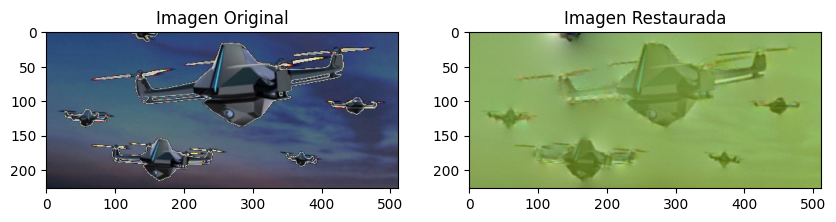

In [ ]:
#@title Procesamiento individual pruebas
import cv2
import numpy as np
import matplotlib.pyplot as plt


# Cargar la imagen y normalizar correctamente
img = cv2.imread("/content/drive/MyDrive/Dataset_modulo/images_1.5/0001.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 256.0

# Restaurar la imagen
img_restaured = recovery_rgb(img)

img_restaured_display = (img_restaured * 255).clip(0, 255).astype(np.uint8)

cv2.imwrite("/content/jejeje.jpg", img_restaured_display)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Imagen Original")
plt.subplot(1, 2, 2)
plt.imshow(img_restaured_display)
plt.title("Imagen Restaurada")
plt.show()


In [ ]:
#@title Definir rutas de entrada y salida
input_folder = "/content/drive/MyDrive/Dataset_modulo/images_3"  # 📂 Carpeta con imágenes originales
output_folder = "/content/drive/MyDrive/dataset_restaured/images_3"  # 📂 Carpeta de salida

# Crear carpeta de salida si no existe
os.makedirs(output_folder, exist_ok=True)
print(f"Carpeta de salida creada: {output_folder}")


Carpeta de salida creada: /content/drive/MyDrive/dataset_restaured/images_3


In [ ]:
#@title Procesamiento completo
import cv2
import numpy as np
from tqdm import tqdm

image_files = [f for f in os.listdir(input_folder) if f.endswith(('.jpg'))]

# Procesar cada imagen
for img_name in tqdm(image_files, desc="Procesando imágenes"):

    img_path = os.path.join(input_folder, img_name)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 256.0

    img_restaured = recovery_rgb(img)
    img_restaured_display = (img_restaured * 255).clip(0, 255).astype(np.uint8)


    # Guardar la imagen en la carpeta de salida
    output_path = os.path.join(output_folder, img_name)
    cv2.imwrite(output_path, img_restaured_display)

print(f"✅ Transformación completada. Imágenes guardadas en {output_folder}")


Procesando imágenes: 100%|██████████| 1359/1359 [04:07<00:00,  5.49it/s]

✅ Transformación completada. Imágenes guardadas en /content/drive/MyDrive/dataset_restaured/images_3
